In [1]:
import numpy as np
import os
import glob
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import collections
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_federated as tff
import random

In [25]:
data_dir_parent = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
ratio = 0.2
for client_num in range(1):
    print(client_num)
    data_dir = data_dir_parent+"/"+str(client_num)
    image_names = []
    labels = []
    for i in range(11):
        data_dir2 = data_dir+"/"+str(i)+"/*.jpg"
        image_names.extend(glob.glob(data_dir2))
        labels.extend(np.ones(len(glob.glob(data_dir2)),dtype=int)*i)
    data = pd.DataFrame(index=range(len(labels)),columns=['image', 'label'])
    for i, (name, label) in enumerate(zip(image_names,labels)):
        img = mpimg.imread(name)
        data.loc[i].image = img
        data.loc[i].label = label
    train, test = train_test_split(data, test_size=ratio, random_state=42)
    data_train = collections.OrderedDict((('label', train.label), ('image', train.image)))
    data_test = collections.OrderedDict((('label', test.label), ('image', test.image)))
    client_train_dataset[client_num] = data_train
    client_test_dataset[client_num] = data_test
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)
test_dataset = tff.simulation.FromTensorSlicesClientData(client_test_dataset)

0


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [26]:
train.image

9031    [[[245, 247, 244], [245, 247, 244], [245, 247,...
8100    [[[67, 59, 46], [66, 58, 45], [64, 56, 43], [6...
8400    [[[138, 139, 167], [139, 141, 166], [141, 143,...
828     [[[120, 118, 97], [121, 119, 98], [121, 119, 9...
6964    [[[115, 99, 73], [115, 99, 73], [115, 99, 73],...
                              ...                        
5734    [[[154, 161, 153], [154, 161, 153], [149, 155,...
5191    [[[127, 128, 132], [128, 129, 133], [129, 128,...
5390    [[[168, 165, 156], [169, 166, 157], [169, 166,...
860     [[[155, 153, 140], [153, 151, 138], [150, 148,...
7270    [[[165, 165, 165], [164, 164, 164], [163, 163,...
Name: image, Length: 8261, dtype: object

In [29]:
train.reset_index(drop=True)

,image,label
0,"[[[245, 247, 244], [245, 247, 244], [245, 247,...",5
1,"[[[67, 59, 46], [66, 58, 45], [64, 56, 43], [6...",5
2,"[[[138, 139, 167], [139, 141, 166], [141, 143,...",5
3,"[[[120, 118, 97], [121, 119, 98], [121, 119, 9...",0
4,"[[[115, 99, 73], [115, 99, 73], [115, 99, 73],...",5
...,...,...
8256,"[[[154, 161, 153], [154, 161, 153], [149, 155,...",1
8257,"[[[127, 128, 132], [128, 129, 133], [129, 128,...",0
8258,"[[[168, 165, 156], [169, 166, 157], [169, 166,...",0
8259,"[[[155, 153, 140], [153, 151, 138], [150, 148,...",0


In [37]:
a = np.zeros((2,3,4))
a

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [40]:
a[0]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [70]:
data_dir_parent = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
ratio = 0.2
for client_num in range(6):
    print(client_num)
    data_dir = data_dir_parent+"/"+str(client_num)
    image_names = []
    labels = []
    for i in range(11):
        data_dir2 = data_dir+"/"+str(i)+"/*.jpg"
        image_names.extend(glob.glob(data_dir2))
        labels.extend(np.ones(len(glob.glob(data_dir2)),dtype=int)*i)
    data = np.zeros((len(image_names),64,64,3))
    for i, name in enumerate(image_names):
        img = PIL.Image.open(name)
        img2 = img.resize((64,64))
        img3 = img2/255.0
        data[i] = img3
    data_train = collections.OrderedDict((('label', labels), ('image', data)))
    client_train_dataset[client_num] = data_train
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

0


TypeError: unsupported operand type(s) for /: 'Image' and 'float'

In [47]:
train_dataset.client_ids

[0]

In [48]:
ts = train_dataset.create_tf_dataset_from_all_clients()

In [49]:
ts

<FlatMapDataset shapes: OrderedDict([(label, ()), (image, (112, 112, 3))]), types: OrderedDict([(label, tf.int32), (image, tf.float64)])>

In [59]:
def preprocess(dataset):

    def batch_format_fn(element):
        return collections.OrderedDict(
                x=element['image'],
                y=tf.reshape(element['label'], [-1, 1]))

    return dataset.shuffle(10000, seed=42).batch(32).map(batch_format_fn)

In [60]:
ts2 = preprocess(ts)

In [61]:
bs = next(iter(ts2))

In [62]:
bs

OrderedDict([('x',
              <tf.Tensor: shape=(32, 112, 112, 3), dtype=float64, numpy=
              array([[[[0.59607843, 0.56862745, 0.49803922],
                       [0.59215686, 0.56470588, 0.49411765],
                       [0.59607843, 0.56862745, 0.49803922],
                       ...,
                       [0.5372549 , 0.62352941, 0.61176471],
                       [0.55294118, 0.63921569, 0.62745098],
                       [0.52941176, 0.62745098, 0.61176471]],
              
                      [[0.58823529, 0.55294118, 0.48627451],
                       [0.58823529, 0.55294118, 0.48627451],
                       [0.58823529, 0.55294118, 0.48627451],
                       ...,
                       [0.51372549, 0.6       , 0.58823529],
                       [0.52941176, 0.61568627, 0.60392157],
                       [0.52156863, 0.61960784, 0.60392157]],
              
                      [[0.60784314, 0.56078431, 0.49803922],
                       [0.6

In [64]:
img2

array([[[0.72156863, 0.7372549 , 0.74901961],
        [0.71764706, 0.73333333, 0.74509804],
        [0.70588235, 0.72156863, 0.7254902 ],
        ...,
        [0.58431373, 0.59215686, 0.57254902],
        [0.58431373, 0.59215686, 0.57254902],
        [0.58431373, 0.59215686, 0.57254902]],

       [[0.76862745, 0.78431373, 0.78823529],
        [0.75294118, 0.76862745, 0.77254902],
        [0.72941176, 0.74509804, 0.74901961],
        ...,
        [0.58431373, 0.59215686, 0.57254902],
        [0.58431373, 0.59215686, 0.57254902],
        [0.58431373, 0.59215686, 0.57254902]],

       [[0.76078431, 0.76862745, 0.76470588],
        [0.76078431, 0.76862745, 0.76470588],
        [0.75686275, 0.76470588, 0.76078431],
        ...,
        [0.58823529, 0.59607843, 0.57647059],
        [0.58823529, 0.59607843, 0.57647059],
        [0.58823529, 0.59607843, 0.57647059]],

       ...,

       [[0.6745098 , 0.6627451 , 0.58823529],
        [0.6745098 , 0.6627451 , 0.58823529],
        [0.6745098 , 0

In [65]:
dsdir = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
class_count = np.zeros((6,11))
for i in range(6):
    dsdiri = dsdir+"/"+str(i)
    for j in range(11):
        dsdirij = dsdiri+"/"+str(j)+'/*.jpg'
        class_count[i,j] += len(glob.glob(dsdirij))

In [66]:
class_count

array([[5728.,  641.,    0.,    0.,    0., 3409.,  127.,  124.,    0.,
           0.,  298.],
       [2686.,  606., 6371.,    0.,    0., 4725.,    0.,    0.,    0.,
         837.,  489.],
       [1406.,  258.,    0.,    0.,  607., 1098.,    0.,    0.,    0.,
          25.,  310.],
       [5231., 1127.,    0., 2033.,    0., 3705.,    0.,    0.,    0.,
         401.,  771.],
       [8684.,  998.,    0.,  316.,    0., 6582.,    0.,  202.,    0.,
         514.,  297.],
       [5415.,  220.,    0.,    0.,  317., 2859.,  113.,   92.,  874.,
           0.,    0.]])

In [71]:
name

'C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset/0/0\\0.jpg'

In [72]:
image = tf.keras.preprocessing.image.load_img(name)

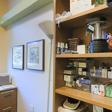

In [73]:
image

In [75]:
np.shape(tf.keras.preprocessing.image.img_to_array(image))

(112, 112, 3)

In [78]:
im1=PIL.Image.open(name)
im2 = im1.resize((64,64))

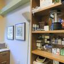

In [79]:
im2

In [82]:
tf.keras.preprocessing.image.img_to_array(im2)/255

array([[[0.62352943, 0.4862745 , 0.24313726],
        [0.6117647 , 0.47843137, 0.25490198],
        [0.5921569 , 0.46666667, 0.2784314 ],
        ...,
        [0.19607843, 0.1882353 , 0.13725491],
        [0.06666667, 0.0627451 , 0.08235294],
        [0.05098039, 0.06666667, 0.12156863]],

       [[0.63529414, 0.5019608 , 0.27450982],
        [0.62352943, 0.49411765, 0.28235295],
        [0.6117647 , 0.48235294, 0.29411766],
        ...,
        [0.27450982, 0.2509804 , 0.19607843],
        [0.18431373, 0.1764706 , 0.18431373],
        [0.28627452, 0.2901961 , 0.3372549 ]],

       [[0.63529414, 0.5137255 , 0.3019608 ],
        [0.627451  , 0.5058824 , 0.29411766],
        [0.62352943, 0.49019608, 0.30588236],
        ...,
        [0.3882353 , 0.34117648, 0.27450982],
        [0.31764707, 0.29411766, 0.2784314 ],
        [0.3137255 , 0.29803923, 0.32156864]],

       ...,

       [[0.40392157, 0.27450982, 0.17254902],
        [0.37254903, 0.25882354, 0.15294118],
        [0.36862746, 0

In [83]:
data_dir_parent = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
ratio = 0.2
for client_num in range(6):
    print(client_num)
    data_dir = data_dir_parent+"/"+str(client_num)
    image_names = []
    labels = []
    for i in range(11):
        data_dir2 = data_dir+"/"+str(i)+"/*.jpg"
        image_names.extend(glob.glob(data_dir2))
        labels.extend(np.ones(len(glob.glob(data_dir2)),dtype=int)*i)
    data = np.zeros((len(image_names),64,64,3))
    for i, name in enumerate(image_names):
        img1=PIL.Image.open(name)
        img2 = img1.resize((64,64))
        data[i] = tf.keras.preprocessing.image.img_to_array(img2)/255
    data_train = collections.OrderedDict((('label', labels), ('image', data)))
    client_train_dataset[client_num] = data_train
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

0
1
2
3
4
5


In [85]:
train_dataset.client_ids

[0, 1, 2, 3, 4, 5]

In [86]:
sum(class_count)

array([29150.,  3850.,  6371.,  2349.,   924., 22378.,   240.,   418.,
         874.,  1777.,  2165.])

In [96]:
a = ["ali","veli","musa"]
tf.random.shuffle(a).numpy()[0]

b'ali'

In [12]:
data_dir_parent = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
ratio = 0.2
ratio0and5 = 0.2
for client_num in range(6):
    print(client_num)
    data_dir = data_dir_parent+"/"+str(client_num)
    image_names = []
    labels = []
    for i in range(11):
        data_dir2 = data_dir+"/"+str(i)+"/*.jpg"
        if len(glob.glob(data_dir2))>0:
            if i == 0 or i == 5:
                temp_names=glob.glob(data_dir2)
                full_len = len(temp_names)
                used_len = int(ratio0and5*full_len)
                random.shuffle(temp_names)
                used_names = temp_names[:used_len]
                image_names.extend(used_names)
                labels.extend(np.ones(len(used_names),dtype=int)*i)
            else:
                image_names.extend(glob.glob(data_dir2))
                labels.extend(np.ones(len(glob.glob(data_dir2)),dtype=int)*i)
    data = np.zeros((len(image_names),112,112,3))
    for i, name in enumerate(image_names):
        img1 = PIL.Image.open(name)
        data[i] = tf.keras.preprocessing.image.img_to_array(img1)/255
    data_train = collections.OrderedDict((('label', labels), ('image', data)))
    client_train_dataset[client_num] = data_train
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

0
1
2
3
4
5


In [13]:
def preprocess(dataset):

    def batch_format_fn(element):
        return collections.OrderedDict(
                x=element['image'],
                y=tf.reshape(element['label'], [-1, 1]))

    return dataset.shuffle(10000, seed=42).batch(128).map(batch_format_fn)

In [14]:
ts = [preprocess(train_dataset.create_tf_dataset_for_client(x)) for x in train_dataset.client_ids]

In [15]:
class_count2 = np.zeros((6,11))
for client_num in range(6):
    print(client_num)
    ds = ts[client_num]
    for batch in ds:
        for y in batch['y']:
            class_count2[client_num,y] += 1

0
1
2
3
4
5


In [16]:
class_count2

array([[1145.,  641.,    0.,    0.,    0.,  681.,  127.,  124.,    0.,
           0.,  298.],
       [ 537.,  606., 6371.,    0.,    0.,  945.,    0.,    0.,    0.,
         837.,  489.],
       [ 281.,  258.,    0.,    0.,  607.,  219.,    0.,    0.,    0.,
          25.,  310.],
       [1046., 1127.,    0., 2033.,    0.,  741.,    0.,    0.,    0.,
         401.,  771.],
       [1736.,  998.,    0.,  316.,    0., 1316.,    0.,  202.,    0.,
         514.,  297.],
       [1083.,  220.,    0.,    0.,  317.,  571.,  113.,   92.,  874.,
           0.,    0.]])

In [19]:
dsdir = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
class_count = np.zeros((6,11))
for i in range(6):
    dsdiri = dsdir+"/"+str(i)
    for j in range(11):
        dsdirij = dsdiri+"/"+str(j)+'/*.jpg'
        class_count[i,j] += len(glob.glob(dsdirij))

In [20]:
class_count

array([[5728.,  641.,    0.,    0.,    0., 3409.,  127.,  124.,    0.,
           0.,  298.],
       [2686.,  606., 6371.,    0.,    0., 4725.,    0.,    0.,    0.,
         837.,  489.],
       [1406.,  258.,    0.,    0.,  607., 1098.,    0.,    0.,    0.,
          25.,  310.],
       [5231., 1127.,    0., 2033.,    0., 3705.,    0.,    0.,    0.,
         401.,  771.],
       [8684.,  998.,    0.,  316.,    0., 6582.,    0.,  202.,    0.,
         514.,  297.],
       [5415.,  220.,    0.,    0.,  317., 2859.,  113.,   92.,  874.,
           0.,    0.]])

In [21]:
sum(class_count2)

array([5828., 3850., 6371., 2349.,  924., 4473.,  240.,  418.,  874.,
       1777., 2165.])

In [23]:
train, test = train_test_split(image_names, test_size=0.2, random_state=42)

In [26]:
len(train)

2616

In [28]:
len(test)*4

2616

In [37]:
dr = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset/0/0/*.jpg"
image_names = glob.glob(dr)

In [34]:
train, test = train_test_split(image_names, test_size=0.2, random_state=42)

In [2]:
data_dir_parent = "C:/Users/temmuz/Desktop/2022-2/proje/stanford/dataset"
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
ratio = 0.2
ratio0and5 = 0.2
for client_num in range(6):
    print(client_num)
    data_dir = data_dir_parent+"/"+str(client_num)
    train_image_names = []
    test_image_names = []
    labels_train = []
    labels_test = []
    for i in range(11):
        data_dir2 = data_dir+"/"+str(i)+"/*.jpg"
        if len(glob.glob(data_dir2))>0:
            temp_names=glob.glob(data_dir2)
            train, test = train_test_split(temp_names, test_size=0.2, random_state=42)
            test_image_names.extend(test)
            labels_test.extend(np.ones(len(test),dtype=int)*i)
            if i == 0 or i == 5:
                full_len = len(train)
                used_len = int(ratio0and5*full_len)
                used_names = train[:used_len]
                train_image_names.extend(used_names)
                labels_train.extend(np.ones(len(used_names),dtype=int)*i)
            else:
                train_image_names.extend(train)
                labels_train.extend(np.ones(len(train),dtype=int)*i)
    data_train = np.zeros((len(train_image_names),112,112,3))
    data_test = np.zeros((len(test_image_names),112,112,3))
    for i, name in enumerate(train_image_names):
        img1 = PIL.Image.open(name)
        data_train[i] = tf.keras.preprocessing.image.img_to_array(img1)/255
    for i, name in enumerate(test_image_names):
        img1 = PIL.Image.open(name)
        data_test[i] = tf.keras.preprocessing.image.img_to_array(img1)/255
    data_train = collections.OrderedDict((('label', labels_train), ('image', data_train)))
    data_test = collections.OrderedDict((('label', labels_test), ('image', data_test)))
    client_train_dataset[client_num] = data_train
    client_test_dataset[client_num] = data_test
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)
test_dataset = tff.simulation.FromTensorSlicesClientData(client_test_dataset)

0
1
2
3
4
5


In [4]:
def preprocess(dataset):

    def batch_format_fn(element):
        return collections.OrderedDict(
                x=element['image'],
                y=tf.reshape(element['label'], [-1, 1]))

    return dataset.shuffle(10000, seed=42).batch(128).map(batch_format_fn)

In [5]:
ts = [preprocess(train_dataset.create_tf_dataset_for_client(x)) for x in train_dataset.client_ids]
tes = [preprocess(test_dataset.create_tf_dataset_for_client(x)) for x in test_dataset.client_ids]

In [12]:
class_count_train = np.zeros((6,11))
for client_num in range(6):
    print(client_num)
    ds = ts[client_num]
    for batch in ds:
        for y in batch['y']:
            class_count_train[client_num,y] += 1

0
1
2
3
4
5


In [17]:
class_count_train

array([[ 916.,  512.,    0.,    0.,    0.,  545.,  101.,   99.,    0.,
           0.,  238.],
       [ 429.,  484., 5096.,    0.,    0.,  756.,    0.,    0.,    0.,
         669.,  391.],
       [ 224.,  206.,    0.,    0.,  485.,  175.,    0.,    0.,    0.,
          20.,  248.],
       [ 836.,  901.,    0., 1626.,    0.,  592.,    0.,    0.,    0.,
         320.,  616.],
       [1389.,  798.,    0.,  252.,    0., 1053.,    0.,  161.,    0.,
         411.,  237.],
       [ 866.,  176.,    0.,    0.,  253.,  457.,   90.,   73.,  699.,
           0.,    0.]])

In [14]:
sum(sum(class_count_train))

23400.0

In [9]:
class_count_test = np.zeros((6,11))
for client_num in range(6):
    print(client_num)
    ds = tes[client_num]
    for batch in ds:
        for y in batch['y']:
            class_count_test[client_num,y] += 1

0
1
2
3
4
5


In [11]:
sum(class_count_test)

array([5833.,  773., 1275.,  471.,  186., 4477.,   49.,   85.,  175.,
        357.,  435.])

In [15]:
a = ["ali","veli"]

In [16]:
a*2

['ali', 'veli', 'ali', 'veli']

In [2]:
a = ["ali","veli","musa","mustafa"]
b = [0,2]

In [3]:
c =  [a[x] for x in b]

In [5]:
c

['ali', 'musa']